# Name: Aniruddh Kulkarni

# Roll no: I081          

# Stream: CS (AI)      

# Division: I

# Semester: 5th Semester        

# Batch: I-3            

# Subject: NLP

# Assignment-6

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Generate and plot a synthetic imbalanced classification dataset
from collections import Counter
import numpy as np
import pandas as pd # to work with csv files

# matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

# import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import _stop_words
from sklearn.feature_extraction.text import TfidfVectorizer

# pre-processing of text
import string
import re

# import classifiers from sklearn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

# import time function from time module to track the training duration
from time import time

# importing required ml model libraries
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Sequential 
from keras.preprocessing.text import Tokenizer

from sklearn import metrics

%pip install imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE


  Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
our_data = pd.read_csv("Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1" )

In [5]:
our_data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/2015 17:48:27,3.0,0.6400,yes,0.640,wsj_398217788,1991-08-14,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/2015 16:54:25,NaN,NaN,no,1.000,wsj_399019502,2007-08-21,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/2015 01:59:03,NaN,NaN,no,1.000,wsj_398284048,1991-11-14,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/2015 02:19:39,NaN,0.0000,no,0.675,wsj_397959018,1986-06-16,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/2015 17:48:27,3.0,0.3257,yes,0.640,wsj_398838054,2002-10-04,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [6]:
our_data.shape # Number of rows (instances) and columns in the dataset

(8000, 15)

In [7]:
our_data["relevance"].unique()

array(['yes', 'no', 'not sure'], dtype=object)

In [8]:
our_data["relevance"].value_counts()

relevance
no          6571
yes         1420
not sure       9
Name: count, dtype: int64

In [9]:
our_data["relevance"].value_counts()/our_data.shape[0] # Class distribution in the dataset

relevance
no          0.821375
yes         0.177500
not sure    0.001125
Name: count, dtype: float64

In [10]:
# convert label to a numerical variable
our_data = our_data[our_data.relevance != "not sure"] # removing the data where we don't want relevance="not sure".
our_data.shape

(7991, 15)

In [11]:
our_data['relevance'] = our_data.relevance.map({'yes':1, 'no':0}) # relevant is 1, not-relevant is 0. 

In [12]:
our_data = our_data[["text","relevance"]] # Let us take only the two columns we need.
our_data

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1
...,...,...
7995,Secretary of Commerce Charles W. Sawyer said y...,1
7996,"U.S. stocks inched up last week, overcoming co...",0
7997,Ben S. Bernanke cleared a key hurdle Thursday ...,0
7998,The White House's push to contract out many fe...,0


In [13]:
our_data.shape

(7991, 2)

In [14]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pushpakulkarni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def clean(doc): # doc is a string of text
    doc = doc.replace("</br>", " ") # This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    # remove punctuation and numbers
    return doc
our_data['text'] = our_data['text'].apply(clean)    

In [16]:
def special_char(text):
  reviews = ''
  for x in text:
    if x.isalnum():
      reviews = reviews + x
    else:
      reviews = reviews + ' '
  return reviews
our_data['text'] = our_data['text'].apply(special_char)

In [17]:
def convert_lower(text):
   return text.lower()
our_data['text'] = our_data['text'].apply(convert_lower)
our_data['text'][1]

'the wall street journal online the morning brief look days biggest news emailed subscribers every business day sign email on friday evening congress town summer recess americans heading midaugust weekend bush administration sent message states the federal government make tougher national childrens insurance program cover offspring middleincome families the state childrens health insurance program created help children whose families couldnt afford insurance didnt qualify medicaid administration officials tell new york times changes aimed returning program low income focus assuring didnt become replacement private insurance administration point man dennis smith wrote state officials saying would new restrictions district columbia states including california new york extend plan extend coverage children whose families make federal poverty levels for family three family four under new limits child family making would spend one year uninsured qualifying state wants extend coverage would a

In [18]:
x = our_data['text']
y = our_data['relevance']
our_data

,text,relevance
0,new york yields certificates deposit offered m...,1
1,the wall street journal online the morning bri...,0
2,washington in effort achieve banking reform se...,0
3,the statistics enormous costs employee drug ab...,0
4,new york indecision marked dollars tone trader...,1
...,...,...
7995,secretary commerce charles w sawyer said yeste...,1
7996,us stocks inched last week overcoming concern ...,0
7997,ben s bernanke cleared key hurdle thursday con...,0
7998,the white houses push contract many federal fu...,0


In [19]:
#BOW 1000 max feat
x1 = np.array(our_data.iloc[:,0].values)
y1 = np.array(our_data.relevance.values)
cv = CountVectorizer(max_features = 1000)
x1 = cv.fit_transform(our_data.text).toarray()
print("X.shape = ",x1.shape)
print("y.shape = ",y1.shape)

X.shape =  (7991, 1000)
y.shape =  (7991,)


In [20]:
#BOW 5000 max feat
x2 = np.array(our_data.iloc[:,0].values)
y2 = np.array(our_data.relevance.values)
cv2 = CountVectorizer(max_features = 5000)
x2 = cv2.fit_transform(our_data.text).toarray()
print("X.shape = ",x2.shape)
print("y.shape = ",y2.shape)

X.shape =  (7991, 5000)
y.shape =  (7991,)


In [21]:
#Bag of N Grams 1000 feat
x3 = np.array(our_data.iloc[:,0].values)
y3 = np.array(our_data.relevance.values)
count_vect = CountVectorizer(ngram_range=(2,3),max_features = 1000)

x3 = count_vect.fit_transform(our_data.text).toarray()

print("X.shape = ",x3.shape)
print("y.shape = ",y3.shape)

X.shape =  (7991, 1000)
y.shape =  (7991,)


In [22]:
#Bag of N Grams 5000 feat
x4 = np.array(our_data.iloc[:,0].values)
y4 = np.array(our_data.relevance.values)
count_vect2 = CountVectorizer(ngram_range=(2,3),max_features = 5000)

x4 = count_vect2.fit_transform(our_data.text).toarray()

print("X.shape = ",x4.shape)
print("y.shape = ",y4.shape)

X.shape =  (7991, 5000)
y.shape =  (7991,)


In [23]:
#TF-IDF 1000 feat
x5 = np.array(our_data.iloc[:,0].values)
y5 = np.array(our_data.relevance.values)

tfidf = TfidfVectorizer(max_features = 1000)
x5 = tfidf.fit_transform(our_data.text).toarray()

print("X.shape = ",x5.shape)
print("y.shape = ",y5.shape)

X.shape =  (7991, 1000)
y.shape =  (7991,)


In [24]:
#TF-IDF 5000 feat
x6 = np.array(our_data.iloc[:,0].values)
y6 = np.array(our_data.relevance.values)

tfidf2 = TfidfVectorizer(max_features = 5000)
x6 = tfidf2.fit_transform(our_data.text).toarray()

print("X.shape = ",x6.shape)
print("y.shape = ",y6.shape)

X.shape =  (7991, 5000)
y.shape =  (7991,)


In [25]:
#BoW 1000 feat
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train1))
print(len(x_test1))

#BoW 5000 feat
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train2))
print(len(x_test2))


#Bag of n gram 1000 feat
x_train3, x_test3, y_train3, y_test3 = train_test_split(x3, y3, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train3))
print(len(x_test3))

#Bag of n gram 5000 feat
x_train4, x_test4, y_train4, y_test4 = train_test_split(x4, y4, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train4))
print(len(x_test4))



#TF-IDF 1000 feat
x_train5, x_test5, y_train5, y_test5 = train_test_split(x5, y5, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train5))
print(len(x_test5))


#TF-IDF 5000 feat
x_train6, x_test6, y_train6, y_test6 = train_test_split(x6, y6, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train6))
print(len(x_test6))

5593
2398
5593
2398
5593
2398
5593
2398
5593
2398
5593
2398


In [26]:
#NORMAL
X_train, X_test, Y_train, Y_test = train_test_split(x, y, random_state=1)
vect = CountVectorizer(preprocessor=clean)
X_train_dtm = vect.fit_transform(X_train)# use it to extract features from training data
# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)

n_words1 = x_test1.shape[1]
n_words2 = x_test2.shape[1]
n_words3 = x_test3.shape[1]
n_words4 = x_test4.shape[1]
n_words5 = x_test5.shape[1]
n_words6 = x_test6.shape[1]

In [27]:
#create list of model and accuracy dicts
perform_list1 = [ ]
perform_list2 = [ ]
perform_list3 = [ ]
perform_list4 = [ ]
perform_list5 = [ ]

In [28]:
def run_models(x_train, x_test, y_train, y_test, n_words):

  mdl1=''
  mdl2=''
  mdl3=''
  mdl4=''
  mdl5=''

#Multinomial Naive Bayes
  mdl1 = MultinomialNB(alpha=1.0,fit_prior=True)

#Logistic Regression
  mdl2 = LogisticRegression()

#Support Vector Classifer
  mdl3 = SVC()

#Random Forest
  mdl4 = RandomForestClassifier(n_estimators=100 ,criterion='entropy' , random_state=0)

#ANN
  mdl5 = Sequential()
  mdl5.add(Dense(50, input_shape=(n_words,), activation='relu'))
  mdl5.add(Dense(1, activation='sigmoid'))
  mdl5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  
#---------------------------------------------------------------------------------------------------
  print()
  print("FOR NAIVE BAYES: ")
  print()
  mdl1.fit(x_train, y_train)
  y_pred = mdl1.predict(x_test)
  # Performance metrics

  accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)

  # Get precision, recall, f1 scores

  precision, recall, f1score, support = score(y_test, y_pred, average='micro')

  print('Test Accuracy Score of Basic Naive Bayes Model:',accuracy)

  print('Precision :',precision)

  print('Recall :',recall)

  print('F1-score :',f1score)

  #calculate AUC of model
  y_pred_prob = mdl1.predict_proba(x_test)[:, 1]
  auc1 = metrics.roc_auc_score(y_test, y_pred_prob)
  print("ROC_AOC_Score for Naive Bayes: ", auc1)
  

  # Add performance parameters to list

  perform_list1.append(dict([('Model', 'Naive Bayes'),
                            ('Test Accuracy', round(accuracy, 2)),('Precision', round(precision, 2)),('Recall', round(recall, 2)),('F1', round(f1score, 2)),('ROC-AUC', round(auc1, 2))]))
  
#---------------------------------------------------------------------------------------------------
  print()
  print("FOR LOGISTIC REGRESSION: ")
  print()
  mdl2.fit(x_train, y_train)
  y_pred2 = mdl2.predict(x_test)
  # Performance metrics

  accuracy2 = round(accuracy_score(y_test, y_pred2) * 100, 2)

  # Get precision, recall, f1 scores

  precision2, recall2, f1score2, support2 = score(y_test, y_pred2, average='micro')

  print('Test Accuracy Score of Basic Logistic Regression Model:',accuracy2)

  print('Precision :',precision2)

  print('Recall :',recall2)

  print('F1-score :',f1score2)

  #calculate AUC of model
  y_pred_prob = mdl2.predict_proba(x_test)[:, 1]
  auc2 = metrics.roc_auc_score(y_test, y_pred_prob)
  print("ROC_AOC_Score for Logistic Regression: ", auc2)

  # Add performance parameters to list

  perform_list2.append(dict([('Model', 'Logistic Regression'),
                            ('Test Accuracy', round(accuracy2, 2)),('Precision', round(precision2, 2)),('Recall', round(recall2, 2)),('F1', round(f1score2, 2)),('ROC-AUC', round(auc2, 2))]))


#---------------------------------------------------------------------------------------------------

  print()
  print("FOR LINEAR SVC: ")
  print()


  mdl3.fit(x_train, y_train)
  y_pred3 = mdl3.predict(x_test)
  # Performance metrics

  accuracy3 = round(accuracy_score(y_test, y_pred3) * 100, 2)

  # Get precision, recall, f1 scores

  precision3, recall3, f1score3, support3 = score(y_test, y_pred3, average='micro')

  print('Test Accuracy Score of Basic Linear SVC Model:',accuracy3)

  print('Precision :',precision3)

  print('Recall :',recall3)

  print('F1-score :',f1score3)

  #calculate AUC of model
  #y_pred_prob = mdl3.predict_proba(x_test)[:, 1]
  auc3 = metrics.roc_auc_score(y_test, y_pred_prob)
  print("ROC_AOC_Score for Linear SVC: ", auc3)

  # Add performance parameters to list

  perform_list3.append(dict([('Model', 'Linear SVC'),
                            ('Test Accuracy', round(accuracy3, 2)),('Precision', round(precision3, 2)),('Recall', round(recall3, 2)),('F1', round(f1score3, 2)),('ROC-AUC', round(auc3, 2))]))


#---------------------------------------------------------------------------------------------------


  print()
  print("FOR RANDOM FOREST: ")
  print()
  mdl4.fit(x_train, y_train)
  y_pred4 = mdl4.predict(x_test)
  # Performance metrics

  accuracy4 = round(accuracy_score(y_test, y_pred4) * 100, 2)



  # Get precision, recall, f1 scores

  precision4, recall4, f1score4, support4 = score(y_test, y_pred4, average='micro')

  print('Test Accuracy Score of Basic Random Forest Model:',accuracy4)

  print('Precision :',precision4)

  print('Recall :',recall4)

  print('F1-score :',f1score4)

  #calculate AUC of model
  y_pred_prob = mdl4.predict_proba(x_test)[:, 1]
  auc4 = metrics.roc_auc_score(y_test, y_pred_prob)
  print("ROC_AOC_Score for Random Forest: ", auc4)



  # Add performance parameters to list

  perform_list4.append(dict([('Model', 'Random Forest'),
                            ('Test Accuracy', round(accuracy4, 2)),('Precision', round(precision4, 2)),('Recall', round(recall4, 2)),('F1', round(f1score4, 2)),('ROC-AUC', round(auc4, 2))]))



#---------------------------------------------------------------------------------------------------

  print()
  print("FOR ANN: ")
  print()
  mdl5.summary()
  mdl5.fit(x_train, y_train, epochs=50, verbose=2)
  loss, acc = mdl5.evaluate(x_test, y_test, verbose=0)
  #calculate AUC of model
  #y_pred_prob = mdl5.predict_proba(x_test)[:, 1]
  auc5 = metrics.roc_auc_score(y_test, y_pred_prob)
  print("ROC_AOC_Score for ANN: ", auc5)
  print('Test Accuracy:',acc)
  perform_list5.append(dict([('Model', 'ANN'),('Test Accuracy', round(acc, 2)),('Loss',round(loss,2)),('ROC-AUC', round(auc5, 2))]))
                            


In [29]:
run_models(x_train1, x_test1, y_train1, y_test1, n_words1)

Metal device set to: Apple M1

FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 67.76
Precision : 0.6776480400333611
Recall : 0.6776480400333611
F1-score : 0.6776480400333611
ROC_AOC_Score for Naive Bayes:  0.7237625305086854

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 77.36
Precision : 0.7735613010842368
Recall : 0.7735613010842368
F1-score : 0.7735613010842367
ROC_AOC_Score for Logistic Regression:  0.6703189880011768

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 81.61
Precision : 0.8160967472894078
Recall : 0.8160967472894078
F1-score : 0.8160967472894078
ROC_AOC_Score for Linear SVC:  0.6703189880011768

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 81.53
Precision : 0.8152627189324437
Recall : 0.8152627189324437
F1-score : 0.8152627189324437
ROC_AOC_Score for Random Forest:  0.7120753347961224

FOR ANN: 

Model: "sequential"
_______________________________________________________

2023-05-28 00:13:37.947256: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


175/175 - 3s - loss: 0.4458 - accuracy: 0.8183 - 3s/epoch - 20ms/step
Epoch 2/50
175/175 - 1s - loss: 0.3661 - accuracy: 0.8416 - 1s/epoch - 7ms/step
Epoch 3/50
175/175 - 1s - loss: 0.3111 - accuracy: 0.8707 - 1s/epoch - 8ms/step
Epoch 4/50
175/175 - 1s - loss: 0.2478 - accuracy: 0.9056 - 1s/epoch - 8ms/step
Epoch 5/50
175/175 - 1s - loss: 0.1861 - accuracy: 0.9397 - 1s/epoch - 8ms/step
Epoch 6/50
175/175 - 1s - loss: 0.1339 - accuracy: 0.9659 - 1s/epoch - 7ms/step
Epoch 7/50
175/175 - 1s - loss: 0.0908 - accuracy: 0.9837 - 1s/epoch - 7ms/step
Epoch 8/50
175/175 - 1s - loss: 0.0627 - accuracy: 0.9927 - 1s/epoch - 7ms/step
Epoch 9/50
175/175 - 1s - loss: 0.0434 - accuracy: 0.9957 - 1s/epoch - 7ms/step
Epoch 10/50
175/175 - 1s - loss: 0.0310 - accuracy: 0.9968 - 1s/epoch - 7ms/step
Epoch 11/50
175/175 - 1s - loss: 0.0226 - accuracy: 0.9970 - 1s/epoch - 7ms/step
Epoch 12/50
175/175 - 1s - loss: 0.0178 - accuracy: 0.9970 - 1s/epoch - 7ms/step
Epoch 13/50
175/175 - 1s - loss: 0.0147 - accur

In [30]:
run_models(x_train2, x_test2, y_train2, y_test2, n_words2)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 67.26
Precision : 0.6726438698915763
Recall : 0.6726438698915763
F1-score : 0.6726438698915763
ROC_AOC_Score for Naive Bayes:  0.732863682716648

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 76.36
Precision : 0.7635529608006673
Recall : 0.7635529608006673
F1-score : 0.7635529608006673
ROC_AOC_Score for Logistic Regression:  0.6642259718302652

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 81.65
Precision : 0.8165137614678899
Recall : 0.8165137614678899
F1-score : 0.81651376146789
ROC_AOC_Score for Linear SVC:  0.6642259718302652

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 81.61
Precision : 0.8160967472894078
Recall : 0.8160967472894078
F1-score : 0.8160967472894078
ROC_AOC_Score for Random Forest:  0.7122764973529101

FOR ANN: 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)       

In [31]:
run_models(x_train3, x_test3, y_train3, y_test3, n_words3)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 76.65
Precision : 0.7664720600500416
Recall : 0.7664720600500416
F1-score : 0.7664720600500416
ROC_AOC_Score for Naive Bayes:  0.6779253745053785

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 79.36
Precision : 0.7935779816513762
Recall : 0.7935779816513762
F1-score : 0.7935779816513762
ROC_AOC_Score for Logistic Regression:  0.652991682567811

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 81.9
Precision : 0.8190158465387823
Recall : 0.8190158465387823
F1-score : 0.8190158465387823
ROC_AOC_Score for Linear SVC:  0.652991682567811

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 81.69
Precision : 0.816930775646372
Recall : 0.816930775646372
F1-score : 0.816930775646372
ROC_AOC_Score for Random Forest:  0.7088642920182651

FOR ANN: 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)          

In [32]:
run_models(x_train4, x_test4, y_train4, y_test4, n_words4)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 75.65
Precision : 0.7564637197664721
Recall : 0.7564637197664721
F1-score : 0.7564637197664721
ROC_AOC_Score for Naive Bayes:  0.6900736161934696

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 78.15
Precision : 0.7814845704753962
Recall : 0.7814845704753962
F1-score : 0.7814845704753962
ROC_AOC_Score for Logistic Regression:  0.641203905576854

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 81.65
Precision : 0.8165137614678899
Recall : 0.8165137614678899
F1-score : 0.81651376146789
ROC_AOC_Score for Linear SVC:  0.641203905576854

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 81.44
Precision : 0.8144286905754796
Recall : 0.8144286905754796
F1-score : 0.8144286905754796
ROC_AOC_Score for Random Forest:  0.6943974483750601

FOR ANN: 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)        

In [33]:
run_models(x_train5, x_test5, y_train5, y_test5, n_words5)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 82.19
Precision : 0.8219349457881568
Recall : 0.8219349457881568
F1-score : 0.8219349457881568
ROC_AOC_Score for Naive Bayes:  0.7280538045885993

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 81.65
Precision : 0.8165137614678899
Recall : 0.8165137614678899
F1-score : 0.81651376146789
ROC_AOC_Score for Logistic Regression:  0.7340770533987752

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 81.65
Precision : 0.8165137614678899
Recall : 0.8165137614678899
F1-score : 0.81651376146789
ROC_AOC_Score for Linear SVC:  0.7340770533987752

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 81.78
Precision : 0.8177648040033361
Recall : 0.8177648040033361
F1-score : 0.8177648040033361
ROC_AOC_Score for Random Forest:  0.7247009015105796

FOR ANN: 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)        

In [34]:
run_models(x_train6, x_test6, y_train6, y_test6, n_words6)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 81.78
Precision : 0.8177648040033361
Recall : 0.8177648040033361
F1-score : 0.8177648040033361
ROC_AOC_Score for Naive Bayes:  0.7198468373873985

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 81.69
Precision : 0.816930775646372
Recall : 0.816930775646372
F1-score : 0.816930775646372
ROC_AOC_Score for Logistic Regression:  0.7449502965694226

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 81.69
Precision : 0.816930775646372
Recall : 0.816930775646372
F1-score : 0.816930775646372
ROC_AOC_Score for Linear SVC:  0.7449502965694226

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 81.48
Precision : 0.8148457047539617
Recall : 0.8148457047539617
F1-score : 0.8148457047539617
ROC_AOC_Score for Random Forest:  0.7292817101375464

FOR ANN: 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)          

In [35]:
perform_list = perform_list1 + perform_list2 + perform_list3 + perform_list4 + perform_list5 
model_performance_I = pd.DataFrame(data=perform_list)
model_performance_I = model_performance_I[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1', 'Loss']]
model_performance_I

,Model,Test Accuracy,Precision,Recall,F1,Loss
0,Naive Bayes,67.76,0.68,0.68,0.68,NaN
1,Naive Bayes,67.26,0.67,0.67,0.67,NaN
2,Naive Bayes,76.65,0.77,0.77,0.77,NaN
3,Naive Bayes,75.65,0.76,0.76,0.76,NaN
4,Naive Bayes,82.19,0.82,0.82,0.82,NaN
5,Naive Bayes,81.78,0.82,0.82,0.82,NaN
6,Logistic Regression,77.36,0.77,0.77,0.77,NaN
7,Logistic Regression,76.36,0.76,0.76,0.76,NaN
8,Logistic Regression,79.36,0.79,0.79,0.79,NaN
9,Logistic Regression,78.15,0.78,0.78,0.78,NaN


# CLASS BALANCING

In [36]:
our_data["relevance"].value_counts()

relevance
0    6571
1    1420
Name: count, dtype: int64

In [37]:
our_data.isnull().sum()

text         0
relevance    0
dtype: int64

In [38]:
#NO SAMPLING
x8 = x6
y8 = y6

counter = Counter(y8)
print('Count: ',counter)


Count:  Counter({0: 6571, 1: 1420})


In [39]:
#Under Sampling
x9 = x6
y9 = y6

counter = Counter(y9)
print('Before Under Sampling: ',counter)

# transform the dataset
undersample = RandomUnderSampler(sampling_strategy=0.5)  #current sample in minority/0.5 = updated samples in majority class
x9, y9 = undersample.fit_resample(x9, y9)

counter = Counter(y9)
print('After Under Sampling: ',counter)

Before Under Sampling:  Counter({0: 6571, 1: 1420})
After Under Sampling:  Counter({0: 2840, 1: 1420})


In [40]:
#Over Sampling
x10 = x6
y10 = y6

counter = Counter(y10)
print('Before Over Sampling: ',counter)

# transform the dataset
oversample = RandomOverSampler(sampling_strategy=0.5)   #0.5 * majority class = updates sample count in minority
x10, y10 = oversample.fit_resample(x10, y10)

counter = Counter(y10)
print('After Over Sampling: ',counter)

Before Over Sampling:  Counter({0: 6571, 1: 1420})
After Over Sampling:  Counter({0: 6571, 1: 3285})


In [41]:
#SMOTE
x11 = x6
y11 = y6

counter = Counter(y11)
print('Before SMOTE: ',counter)

# transform the dataset
smote = SMOTE(sampling_strategy=0.7)         # 0.7*samples in majority = updated sample count in minority class
x11, y11 = smote.fit_resample(x11, y11)

counter = Counter(y11)
print('After SMOTE: ',counter)

Before SMOTE:  Counter({0: 6571, 1: 1420})
After SMOTE:  Counter({0: 6571, 1: 4599})


In [42]:
#Train test split for class balancing
#No sampling
x_train8, x_test8, y_train8, y_test8 = train_test_split(x8, y8, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train8))
print(len(x_test8))

#Under Sampling
x_train9, x_test9, y_train9, y_test9 = train_test_split(x9, y9, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train9))
print(len(x_test9))


#Over Sampling
x_train10, x_test10, y_train10, y_test10 = train_test_split(x10, y10, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train10))
print(len(x_test10))

#SMOTE
x_train11, x_test11, y_train11, y_test11 = train_test_split(x11, y11, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train11))
print(len(x_test11))

5593
2398
2982
1278
6899
2957
7819
3351


In [43]:
#Normal
n_words8 = x_test8.shape[1]
n_words9 = x_test9.shape[1]
n_words10 = x_test10.shape[1]
n_words11 = x_test11.shape[1]

In [44]:
#No sampling
run_models(x_train8, x_test8, y_train8, y_test8, n_words8)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 81.78
Precision : 0.8177648040033361
Recall : 0.8177648040033361
F1-score : 0.8177648040033361
ROC_AOC_Score for Naive Bayes:  0.7198468373873985

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 81.69
Precision : 0.816930775646372
Recall : 0.816930775646372
F1-score : 0.816930775646372
ROC_AOC_Score for Logistic Regression:  0.7449502965694226

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 81.69
Precision : 0.816930775646372
Recall : 0.816930775646372
F1-score : 0.816930775646372
ROC_AOC_Score for Linear SVC:  0.7449502965694226

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 81.48
Precision : 0.8148457047539617
Recall : 0.8148457047539617
F1-score : 0.8148457047539617
ROC_AOC_Score for Random Forest:  0.7292817101375464

FOR ANN: 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)          

In [45]:
#Under Sampling
run_models(x_train9, x_test9, y_train9, y_test9, n_words9)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 72.85
Precision : 0.7284820031298904
Recall : 0.7284820031298904
F1-score : 0.7284820031298903
ROC_AOC_Score for Naive Bayes:  0.7564270214709913

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 72.61
Precision : 0.7261345852895149
Recall : 0.7261345852895149
F1-score : 0.7261345852895149
ROC_AOC_Score for Logistic Regression:  0.7587254454088626

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 73.0
Precision : 0.7300469483568075
Recall : 0.7300469483568075
F1-score : 0.7300469483568076
ROC_AOC_Score for Linear SVC:  0.7587254454088626

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 72.3
Precision : 0.7230046948356808
Recall : 0.7230046948356808
F1-score : 0.7230046948356808
ROC_AOC_Score for Random Forest:  0.7427892302421197

FOR ANN: 

Model: "sequential_7"
_________________________________________________________________
 Layer (type)      

In [46]:
#Over Sampling
run_models(x_train10, x_test10, y_train10, y_test10, n_words10)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 73.55
Precision : 0.735542779844437
Recall : 0.735542779844437
F1-score : 0.7355427798444371
ROC_AOC_Score for Naive Bayes:  0.7851504008941004

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 76.73
Precision : 0.7673317551572539
Recall : 0.7673317551572539
F1-score : 0.767331755157254
ROC_AOC_Score for Logistic Regression:  0.8348795876929473

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 86.95
Precision : 0.8694622928643896
Recall : 0.8694622928643896
F1-score : 0.8694622928643896
ROC_AOC_Score for Linear SVC:  0.8348795876929473

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 91.58
Precision : 0.9157930334798783
Recall : 0.9157930334798783
F1-score : 0.9157930334798783
ROC_AOC_Score for Random Forest:  0.9334171552418794

FOR ANN: 

Model: "sequential_8"
_________________________________________________________________
 Layer (type)       

In [47]:
#SMOTE
run_models(x_train11, x_test11, y_train11, y_test11, n_words11)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 72.93
Precision : 0.7293345270068636
Recall : 0.7293345270068636
F1-score : 0.7293345270068636
ROC_AOC_Score for Naive Bayes:  0.8127680486061473

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 79.47
Precision : 0.7946881527902119
Recall : 0.7946881527902119
F1-score : 0.7946881527902119
ROC_AOC_Score for Logistic Regression:  0.8737589935433976

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 89.94
Precision : 0.8994330050731125
Recall : 0.8994330050731125
F1-score : 0.8994330050731125
ROC_AOC_Score for Linear SVC:  0.8737589935433976

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 89.94
Precision : 0.8994330050731125
Recall : 0.8994330050731125
F1-score : 0.8994330050731125
ROC_AOC_Score for Random Forest:  0.9535620437314709

FOR ANN: 

Model: "sequential_9"
_________________________________________________________________
 Layer (type)    

In [48]:
perform_list = perform_list1 + perform_list2 + perform_list3 + perform_list4 + perform_list5 
model_performance_II = pd.DataFrame(data=perform_list)
model_performance_II = model_performance_II[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1', 'Loss']]
model_performance_II

,Model,Test Accuracy,Precision,Recall,F1,Loss
0,Naive Bayes,67.76,0.68,0.68,0.68,NaN
1,Naive Bayes,67.26,0.67,0.67,0.67,NaN
2,Naive Bayes,76.65,0.77,0.77,0.77,NaN
3,Naive Bayes,75.65,0.76,0.76,0.76,NaN
4,Naive Bayes,82.19,0.82,0.82,0.82,NaN
5,Naive Bayes,81.78,0.82,0.82,0.82,NaN
6,Naive Bayes,81.78,0.82,0.82,0.82,NaN
7,Naive Bayes,72.85,0.73,0.73,0.73,NaN
8,Naive Bayes,73.55,0.74,0.74,0.74,NaN
9,Naive Bayes,72.93,0.73,0.73,0.73,NaN


# Output

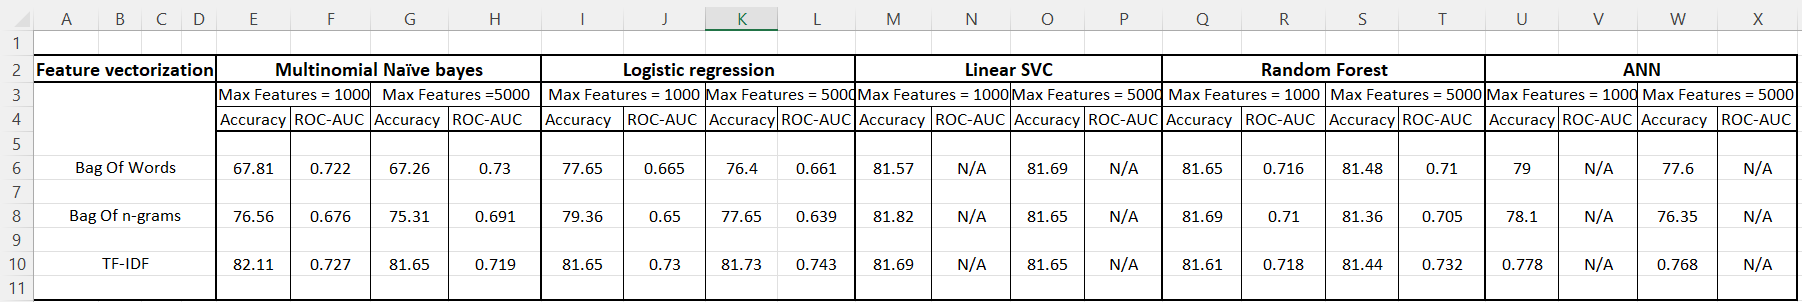

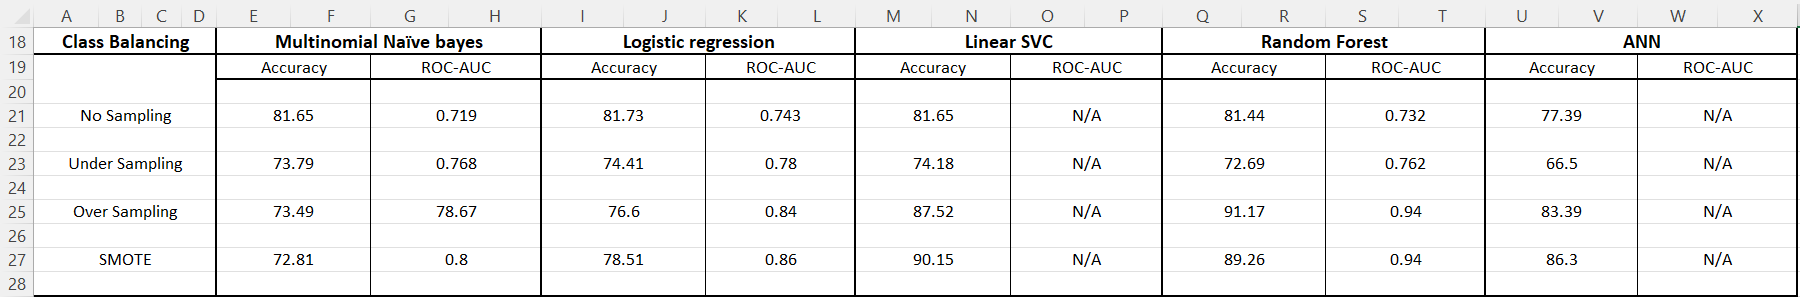

# We can observe that TF-IDF (feature=1000) with Naive Bayes gives the most optimal accuracy at 82.11 % 

For the second case, we can observe that Over sampling with Random Forest gives highest accuracy at 91.17%

Oversampling involves randomly duplicating examples from the minority class and adding them to the training dataset.